In [ ]:
!pip install google-cloud-storage
!pip install pandas

In [13]:
max(df_merge_quality['quality_index_6'])

0.825348029102659

In [14]:
min(df_merge_quality['quality_index_6'])

0.0302222222222222

In [15]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

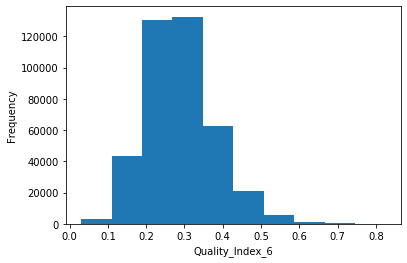

In [16]:
plt.hist(df_merge_quality['quality_index_6'], density=False)  # `density=False` would make counts
plt.ylabel('Frequency')
plt.xlabel('Quality_Index_6');

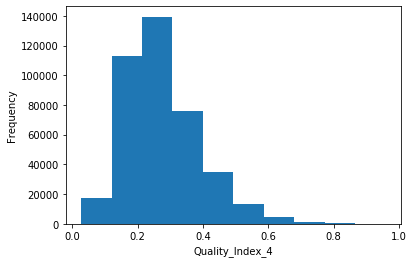

In [42]:
plt.hist(df_merge_quality['quality_index_4'], density=False)  # `density=False` would make counts
plt.ylabel('Frequency')
plt.xlabel('Quality_Index_4');

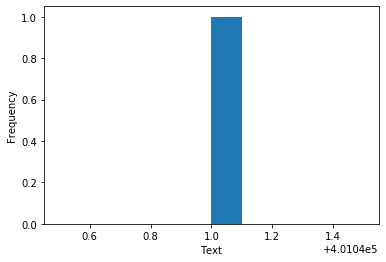

In [43]:
plt.hist(len(df_merge_quality['text']), density=False)  # `density=False` would make counts
plt.ylabel('Frequency')
plt.xlabel('Text');

In [12]:
conditions = [

    (df_merge_quality['quality_index_6'] < 0.3),
    (df_merge_quality['quality_index_6'] >= 0.3)
]

choices = ['0', '1']

In [13]:
import numpy as np
df_merge_quality['quality_rank'] = np.select(condlist=conditions, choicelist=choices)

/home/nobu_yamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
df_merge_quality

,publication_number,application_number,text,filing_date,new_appl_nbr,appln_id,app_nbr,filing,tech_field,many_field,...,fwd_cits7_xy,breakthrough,breakthrough_xy,generality,originality,radicalness,renewal,quality_index_4,quality_index_6,quality_rank
0,EP-2493772-A1,EP-10773469-A,This invention pertains to a U-board split cas...,20101020,EP20100773469,328773105,EP20100773469,2010,25.0,0,...,0,NaN,NaN,NaN,0.602041,0.000000,4.0,0.396296,0.393637,1
4,EP-2813266-A2,EP-14172995-A,A fire suppression system (20) includes a cont...,20100825,EP20140172995,419197262,EP20140172995,2010,24.0,0,...,2,NaN,NaN,0.104938,0.887755,0.571429,9.0,0.420142,0.298506,0
5,EP-2255683-B1,EP-10163204-A,The device has an application device (47) for ...,20100519,EP20100163204,315607513,EP20100163204,2010,34.0,0,...,1,NaN,NaN,NaN,0.642361,0.416667,9.0,0.278788,0.367996,1
6,EP-2262981-B1,EP-10711585-A,The invention relates to a bimetallic valve fo...,20100329,EP20100711585,298884917,EP20100711585,2010,27.0,0,...,0,NaN,NaN,NaN,0.842951,0.675676,7.0,0.300938,0.450909,1
7,EP-2462850-B1,EP-10194739-A,The present invention concerns a beverage prep...,20101213,EP20100194739,329540694,EP20100194739,2010,33.0,0,...,1,NaN,NaN,0.000000,0.668639,0.461538,9.0,0.273246,0.367701,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129085,EP-3346246-A1,EP-18150116-A,Systems and methods for icing resistant total ...,20180102,EP20180150116,488117740,EP20180150116,2018,10.0,0,...,0,NaN,NaN,NaN,0.720000,0.600000,1.0,0.281746,0.206609,0
1129096,EP-3407148-A1,EP-18156651-A,Provided is a highly convenient communication ...,20180214,EP20180156651,489969681,EP20180156651,2018,12.0,1,...,0,NaN,NaN,NaN,0.710744,0.363636,1.0,0.357143,0.267411,0
1129125,EP-3388275-A1,EP-18165679-A,A control device of a four-wheel-drive vehicle...,20180404,EP20180165679,492667799,EP20180165679,2018,31.0,1,...,0,NaN,NaN,NaN,0.856099,0.378378,1.0,0.277778,0.292488,0
1129149,EP-3372398-A1,EP-18159484-A,Roller blind of a sheet material having a sand...,20180301,EP20180159484,490863830,EP20180159484,2018,21.0,0,...,0,NaN,NaN,NaN,0.000000,1.000000,1.0,0.274074,0.180979,0


### create a model

In [17]:
import tensorflow as tf

import tensorflow_hub as hub
import numpy as up
import pandas as pd
from tensorflow.keras import layers
import bert
import pickle as cPickle
from collections import defaultdict
import re

import numpy as np

import sys
import os
from tensorflow import keras

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

In [2]:
patent_abstract = pd.read_csv('patent_abstract_5000.csv')
patent_abstract.shape

(5000, 31)

In [3]:
def tech_field_cat(subcat):
    if subcat <= 8:
        return 0 # for 1. Electrical engineering
    elif subcat <= 13:
        return 1 # for 2. Instruments
    elif subcat <= 24:
        return 2 # for 3. Chemistry
    elif subcat <= 32:
        return 3 # for 4. Mechanical Engineering
    else:
        return 4 # for 5. Other fields

In [4]:
patent_abstract['tech_field_big_cat'] = patent_abstract['tech_field'].apply(tech_field_cat)

In [5]:
df = patent_abstract[['text', 'quality_rank']]

In [6]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [7]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [8]:
abstracts = []
sentences = list(df['text'])
for sen in sentences:
    abstracts.append(preprocess_text(sen))

In [9]:
print(df.columns.values)

['text' 'quality_rank']


In [10]:
df.quality_rank.unique()

array([0, 1])

In [11]:
y = df.quality_rank

In [12]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [13]:
def tokenize_abstracts(text_abstracts):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_abstracts))

In [14]:
tokenized_abstracts = [tokenize_abstracts(abstract) for abstract in abstracts]

In [15]:
abstracts_with_len = [[abstract, y[i], len(abstract)]
                 for i, abstract in enumerate(tokenized_abstracts)]

In [18]:
np.random.shuffle(abstracts_with_len)

In [19]:
abstracts_with_len.sort(key=lambda x: x[2])

In [20]:
sorted_abstracts_labels = [(abstract_lab[0], abstract_lab[1]) for abstract_lab in abstracts_with_len]

In [30]:
sorted_abstracts_labels[6][1]

0

In [23]:
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_abstracts_labels, output_types=(tf.int32, tf.int32))

In [24]:
BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [25]:
next(iter(batched_dataset))

(<tf.Tensor: shape=(32, 23), dtype=int32, numpy=
 array([[ 1037,  8822,  2291,  2005,  2019,  2948,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 1996, 11028, 14623,  2000,  2019, 14794,  9179, 17564,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 4725,  2005,  8225,  1996,  2206,  7328,  2024, 21362,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 1996, 11028, 14623,  2000, 25416, 22648,  7062, 14692,  8670,
         18142,  8962,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 4725,  1998,  9265,  3141,  2000, 14126,  6074,  2000, 13656,
          8153,  2024,  2649,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
      

In [26]:
TOTAL_BATCHES = np.math.ceil(len(sorted_abstracts_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 20
batched_dataset.shuffle(TOTAL_BATCHES)

<ShuffleDataset shapes: ((None, None), (None,)), types: (tf.int32, tf.int32)>

In [29]:
VALIDATION_SPLIT = 0.2

In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

In [34]:
import random
random.shuffle(sorted_abstracts_labels)

In [37]:
labels = []
data = []

for idx in range(len(sorted_abstracts_labels)):
    data.append(sorted_abstracts_labels[idx][0])
    labels.append(sorted_abstracts_labels[idx][1])

In [38]:
labels = to_categorical(np.asarray(labels))

In [40]:
nb_validation_samples = int(VALIDATION_SPLIT * 5000)

In [41]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [42]:
VOCAB_LENGTH = len(tokenizer.vocab)

In [73]:
len(x_train[5])

95

In [55]:
MAX_SENT_LENGTH = 30
MAX_SENTS = 3
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
DROPOUT_RATE = 0.4

NB_EPOCHS = 5

In [56]:
embedding_layer = Embedding(VOCAB_LENGTH,
                            EMBEDDING_DIM)

In [74]:
embedding_layer

In [57]:
class AttLayer(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(AttLayer, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)), name='W')
        self.b = K.variable(self.init((self.attention_dim, )), name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)), name='u')
        self.trainable_weights = [self.W, self.b, self.u]
        super(AttLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
 
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b)) #

        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)

        ait = K.exp(ait)


        #if mask is not None:
        #    # Cast the mask to floatX to avoid float64 upcasting in theano
        #    print('mask')
        #    ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        ait = K.expand_dims(ait)
 
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [58]:
sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
l_att = AttLayer(100)(l_lstm)
sentEncoder = Model(sentence_input, l_att)

tracking <tf.Variable 'att_layer_3/W:0' shape=(200, 100) dtype=float32> W
tracking <tf.Variable 'att_layer_3/b:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'att_layer_3/u:0' shape=(100, 1) dtype=float32> u


In [75]:
sentence_input

<tf.Tensor 'input_3:0' shape=(None, 30) dtype=int32>

In [59]:
embedded_sequences

<tf.Tensor 'embedding_2/embedding_lookup/Identity_1:0' shape=(None, 30, 100) dtype=float32>

In [60]:
abstract_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
abstract_encoder = TimeDistributed(sentEncoder)(abstract_input)
l_lstm_sent = Bidirectional(GRU(30, return_sequences=True))(abstract_encoder)

In [61]:
l_att_sent = AttLayer(100)(l_lstm_sent)

tracking <tf.Variable 'att_layer_4/W:0' shape=(60, 100) dtype=float32> W
tracking <tf.Variable 'att_layer_4/b:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'att_layer_4/u:0' shape=(100, 1) dtype=float32> u


In [62]:
l_att_dense = Dense(100, activation='relu')(l_att_sent)
l_att_dense = Dense(100, activation='relu')(l_att_dense)
l_att_dense = Dense(100, activation='relu')(l_att_dense)
l_att_sent_drop = Dropout(rate=0.4)(l_att_dense)
preds = Dense(2, activation='sigmoid')(l_att_sent_drop)
model = Model(abstract_input, preds)

In [69]:
preds.shape

TensorShape([None, 2])

In [63]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [66]:
x_train

[[1037,
  2093,
  8789,
  4653,
  14709,
  9605,
  2067,
  7138,
  2000,
  12495,
  2102,
  2422,
  2013,
  6942,
  3085,
  18892,
  2015,
  1996,
  2422,
  2108,
  11508,
  3550,
  2012,
  2560,
  2028,
  2422,
  25502,
  5997,
  2007,
  27725,
  2008,
  2064,
  2022,
  2275,
  2000,
  2689,
  1996,
  11508,
  3989,
  1997,
  2422,
  11508,
  17629,
  2008,
  19818,
  2015,
  2422,
  2306,
  3132,
  2846,
  1997,
  11508,
  22318,
  2073,
  2169,
  2422,
  25502,
  5997,
  2064,
  2689,
  1996,
  11508,
  3989,
  2107,
  2008,
  1996,
  2422,
  4458,
  2083,
  1996,
  11508,
  17629,
  2064,
  2119,
  3623,
  1998,
  9885,
  20868,
  6072,
  5051,
  15277,
  1997,
  1996,
  11508,
  3989,
  1997,
  2422,
  2077,
  4458,
  1996,
  5997,
  1998,
  2073,
  1996,
  11991,
  1997,
  1996,
  18892,
  2015,
  2024,
  26351,
  8093,
  27296,
  2098,
  2007,
  1996,
  11991,
  1997,
  1996,
  27725,
  2006,
  1996,
  2012,
  2560,
  2028,
  2422,
  25502,
  5997],
 [1996,
  2556,
  11028,
  14

In [68]:
print("model fitting - Hierachical attention network")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=5, batch_size=32)

model fitting - Hierachical attention network


/home/nobu_yamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 4000 arrays: [array([[ 1037],
       [ 2093],
       [ 8789],
       [ 4653],
       [14709],
       [ 9605],
       [ 2067],
       [ 7138],
       [ 2000],
       [12495],
       [ 2102],
       [ 2422],
       ...

In [21]:
from nltk import tokenize

abstracts = []
labels = []
texts = []

for idx in range(data_train.text.shape[0]):

    text = clean_str(str(data_train.iloc[idx]['text']))
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    abstracts.append(sentences)
    labels.append(data_train.iloc[idx]['quality_rank'])

In [22]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

In [23]:
data.shape

(5000, 3, 30)

In [24]:
for i, sentences in enumerate(abstracts):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
            #for word in wordTokens:
                if word in tokenizer.word_index.keys():
                    if (k < MAX_SENT_LENGTH) and (tokenizer.word_index[word] < MAX_NB_WORDS):
                        data[i, j, k] = tokenizer.word_index[word]
                        k = k + 1

In [25]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 17722 unique tokens.


In [26]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (5000, 3, 30)
Shape of label tensor: (5000, 2)


In [27]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

In [28]:
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [29]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [30]:
print('Number of positive and negative reviews in traing and validation set')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))

Number of positive and negative reviews in traing and validation set
[2308. 1692.]
[596. 404.]


In [31]:
# Standard python helper libraries.
import os, sys, re, json, time
import itertools, collections
from importlib import reload
from IPython.display import display

# NumPy and SciPy for matrix ops

import scipy.sparse


# Helper libraries
#from w266_common import utils, vocabulary, tf_embed_viz
#import glove_helper; reload(glove_helper)

#hands = glove_helper.Hands(ndim=100)  # 50, 100, 200, 300 dim are available

In [38]:
import zipfile
with zipfile.ZipFile("data/glove/glove.6B.zip", 'r') as zip_ref:
    zip_ref.extractall("data/glove")

In [32]:
GLOVE_DIR = "data/glove"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [33]:
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [62]:
# building Hierachical Attention network
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            trainable=False)

In [63]:
class AttLayer(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(AttLayer, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)), name='W')
        self.b = K.variable(self.init((self.attention_dim, )), name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)), name='u')
        self.trainable_weights = [self.W, self.b, self.u]
        super(AttLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
 
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b)) #

        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)

        ait = K.exp(ait)


        #if mask is not None:
        #    # Cast the mask to floatX to avoid float64 upcasting in theano
        #    print('mask')
        #    ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        ait = K.expand_dims(ait)
 
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [46]:
class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """
    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self.trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

In [66]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x,mask=None):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        print(at)
        output=x*at
        print(output)
        print(K.sum(output,axis=1))
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [71]:
sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
l_att = AttLayer(100)(l_lstm)
sentEncoder = Model(sentence_input, l_att)

tracking <tf.Variable 'att_layer_8/W:0' shape=(200, 100) dtype=float32> W
tracking <tf.Variable 'att_layer_8/b:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'att_layer_8/u:0' shape=(100, 1) dtype=float32> u


In [72]:
abstract_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
abstract_encoder = TimeDistributed(sentEncoder)(abstract_input)
l_lstm_sent = Bidirectional(GRU(30, return_sequences=True))(abstract_encoder)

In [75]:
abstract_input.shape

TensorShape([None, 3, 30])

In [46]:
abstract_encoder.shape

TensorShape([None, 3, 200])

In [39]:
l_lstm_sent.shape

TensorShape([None, 3, 60])

In [73]:
#l_att_sent = AttLayer(100)(l_lstm_sent)
l_att_sent = AttLayer(100)(l_lstm_sent)

tracking <tf.Variable 'att_layer_9/W:0' shape=(60, 100) dtype=float32> W
tracking <tf.Variable 'att_layer_9/b:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'att_layer_9/u:0' shape=(100, 1) dtype=float32> u


In [74]:
l_att_dense = Dense(100, activation='relu')(l_att_sent)
l_att_dense = Dense(100, activation='relu')(l_att_dense)
l_att_dense = Dense(100, activation='relu')(l_att_dense)
l_att_sent_drop = Dropout(rate=0.5)(l_att_dense)
preds = Dense(2, activation='relu')(l_att_sent_drop)
model = Model(abstract_input, preds)

In [75]:
preds.shape

TensorShape([None, 2])

In [76]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [77]:
print("model fitting - Hierachical attention network")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=10, batch_size=50)

model fitting - Hierachical attention network


/home/nobu_yamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 23s 6ms/step - loss: 0.9415 - acc: 0.5176 - val_loss: 0.6765 - val_acc: 0.5945
Epoch 2/10
4000/4000 [==============================] - 19s 5ms/step - loss: 0.7187 - acc: 0.5311 - val_loss: 0.6806 - val_acc: 0.5895
Epoch 3/10
4000/4000 [==============================] - 19s 5ms/step - loss: 0.7082 - acc: 0.5326 - val_loss: 0.6765 - val_acc: 0.5930
Epoch 4/10
4000/4000 [==============================] - 19s 5ms/step - loss: 0.7065 - acc: 0.5356 - val_loss: 0.6764 - val_acc: 0.5945
Epoch 5/10
4000/4000 [==============================] - 19s 5ms/step - loss: 0.7028 - acc: 0.5477 - val_loss: 0.6806 - val_acc: 0.5865
Epoch 6/10
4000/4000 [==============================] - 19s 5ms/step - loss: 0.7013 - acc: 0.5444 - val_loss: 0.6818 - val_acc: 0.5510
Epoch 7/10
4000/4000 [==============================] - 19s 5ms/step - loss: 0.7003 - acc: 0.5454 - val_loss: 0.6809 - val_acc: 0.5955
Epoch 8